# Quantitative Class Separation Metrics for Hidden Representations in Deep Neural Networks

**02456 DEEP LEARNING, DTU COMPUTE, FALL 2025**

**Student: Bashar bdewi (s183356)**

---

We implement and evaluate **quantitative class-separation metrics** for hidden representations in deep neural networks, with a focus on **image classification models** (MNIST and CIFAR-10).

Instead of only looking at test accuracy or qualitative t-SNE plots, we build a reusable toolbox that measures **how well different layers separate classes** in embedding space.

The deep learning/XAI pipeline includes:

- Train simple neural networks on toy data (2D half-moons) and image data (MNIST / CIFAR-10).
- Extract hidden-layer representations (embeddings).
- Compute quantitative class-separation metrics on these embeddings.
- Study how these metrics evolve across layers and epochs, and how they relate to accuracy and overfitting.





# Basic setup – imports, seeding, and device selection

In [1]:
# ============================================
# Imports and configuration
# ============================================


import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import torch
import torch.nn as nn
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import silhouette_score

from tqdm.auto import tqdm


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# --------------------------------------------
# Device selection (CPU / GPU)
# --------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {DEVICE}")


def set_seed(seed: int = 42) -> None:
 
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make CuDNN deterministic (may reduce performance but improves reproducibility)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




set_seed(42)


def to_device(x: Any, device: torch.device = DEVICE):
    if torch.is_tensor(x):
        return x.to(device)
    elif isinstance(x, (list, tuple)):
        return type(x)(to_device(v, device) for v in x)
    elif isinstance(x, dict):
        return {k: to_device(v, device) for k, v in x.items()}
    else:
        return x


print("[Info] Environment is ready: imports OK, seed set, device selected.")


[Info] Using device: cpu
[Info] Environment is ready: imports OK, seed set, device selected.


## 1. Toy 2D dataset and baseline MLP classifier

Before applying class separation metrics to larger deep networks (MNIST, CIFAR-10), we start with
a very small and fully interpretable setting:


Below, we:
1. Generate the toy dataset and split it into train/validation/test.
2. Define a simple `SimpleMLP` model.
3. Implement a small training loop with accuracy tracking.
4. Train the model and confirm it reaches high accuracy on this simple task.


X shape: (600, 2)  y shape: (600,)


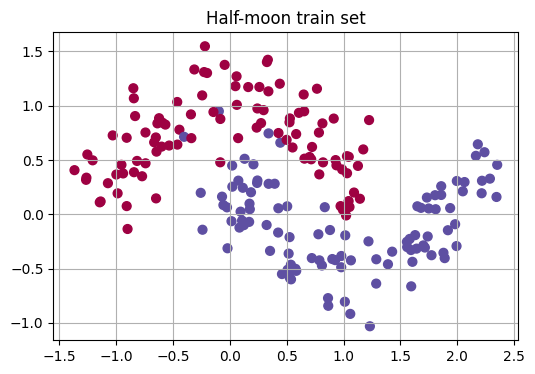

SimpleHalfMoonNet(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)
Logits shape: torch.Size([200, 2])
Dataloaders ready.


In [4]:
# ============================================
# Environment setup + toy 2D half-moon problem
# ============================================
try:
    from sklearn.datasets import make_moons
except ImportError as e:
    raise ImportError(
        "scikit-learn is required for the half-moon dataset. "
        "Install it with: pip install scikit-learn"
    ) from e

# -------------------------------------------------
# Generate 2D half-moon dataset (toy classification)
# -------------------------------------------------
N_SAMPLES = 600

# Use noise for non-linearity; np seed is already set, but we can also fix random_state
X, y = make_moons(N_SAMPLES, noise=0.20)  # optionally: random_state=42

X = X.astype("float32")
y = y.astype("int64")

# (Optional) shuffle before splitting to ensure all splits are well-mixed
perm = np.random.permutation(N_SAMPLES)
X, y = X[perm], y[perm]

# Split into train / val / test (200 / 200 / 200)
X_train, y_train = X[:200],   y[:200]
X_val,   y_val   = X[200:400], y[200:400]
X_test,  y_test  = X[400:600], y[400:600]

print("X shape:", X.shape, " y shape:", y.shape)

# Quick scatter plot of train set
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, s=40)
plt.title("Half-moon train set")
plt.show()

# ---------------------------------------
# Build simple MLP classifier in PyTorch
# ---------------------------------------
class SimpleHalfMoonNet(nn.Module):
    
    def __init__(self, input_dim: int = 2, hidden_dim: int = 16, num_classes: int = 2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch_size, 2]
        h = self.act(self.fc1(x))
        logits = self.fc2(h)
        return logits

model = SimpleHalfMoonNet().to(DEVICE)
print(model)

# ------------------------------
# Sanity check: forward pass
# ------------------------------
X_train_t = torch.from_numpy(X_train).to(DEVICE)
y_train_t = torch.from_numpy(y_train).to(DEVICE)

with torch.no_grad():
    logits = model(X_train_t)
print("Logits shape:", logits.shape)

# ------------------------------
# Build simple DataLoaders
# ------------------------------
batch_size = 64

train_ds = TensorDataset(
    torch.from_numpy(X_train), torch.from_numpy(y_train)
)
val_ds = TensorDataset(
    torch.from_numpy(X_val), torch.from_numpy(y_val)
)
test_ds = TensorDataset(
    torch.from_numpy(X_test), torch.from_numpy(y_test)
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Dataloaders ready.")


## 2. MNIST baseline: simple CNN + class separation metrics

model → embeddings → metrics, all running on a real dataset (MNIST).


In [7]:
# ------------------------------------------------------------------
# Config and device
# ------------------------------------------------------------------

@dataclass
class Config:
    dataset: str = "MNIST"
    data_root: str = "./data"
    batch_size: int = 128
    num_workers: int = 2
    lr: float = 1e-3
    weight_decay: float = 1e-4    
    num_epochs: int = 5
    seed: int = 42
    # Keep a string version of the device for logging
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# Single global config object
config = Config()

# Use the same seed helper as before for full reproducibility
set_seed(config.seed)

# Keep a single device object throughout the notebook
device = DEVICE   # alias to the global DEVICE defined earlier
config.device = str(device)
print(f"[Info] Using device: {device}")

# -------------------------------------------------------------------
# MNIST transforms and dataset loading
# -------------------------------------------------------------------
# MNIST: 28x28 grayscale images, values in [0,1] -> normalized
transform = transforms.Compose([
    transforms.ToTensor(),                      
    transforms.Normalize((0.1307,), (0.3081,))  
])

# Load the full training set (60k images)
full_train_dataset = torchvision.datasets.MNIST(
    root=config.data_root,
    train=True,
    download=True,
    transform=transform,
)

# Load the test set (10k images)
test_dataset = torchvision.datasets.MNIST(
    root=config.data_root,
    train=False,
    download=True,
    transform=transform,
)

# -------------------------------------------------------------------
# Train / validation split
# -------------------------------------------------------------------
train_size = 50_000
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(config.seed),
)

print(f"Train size: {len(train_dataset)}, "
      f"Val size: {len(val_dataset)}, "
      f"Test size: {len(test_dataset)}")

# -------------------------------------------------------------------
# DataLoaders
# -------------------------------------------------------------------
pin_mem = (device.type == "cuda")

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=pin_mem,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=pin_mem,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=pin_mem,
)

# Peek at one batch to verify shapes
images, labels = next(iter(train_loader))
print(f"Batch images shape: {images.shape}  (B, C, H, W)")
print(f"Batch labels shape: {labels.shape}")

# -------------------------------------------------------------------
# Baseline CNN model with feature extraction
# -------------------------------------------------------------------
class SimpleMNISTCNN(nn.Module):

    def __init__(self, num_classes: int = 10):
        super().__init__()
        # Convolutional feature extractor
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),                             

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),                           
        )

        # Fully connected classifier
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # penultimate layer
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor, return_features: bool = False):
      
        x = self.conv_blocks(x)
        x = self.flatten(x)
        features = torch.relu(self.fc1(x))   # penultimate features
        logits = self.fc2(features)

        if return_features:
            return logits, features
        return logits

# Instantiate the model and move to device
model = SimpleMNISTCNN(num_classes=10).to(device)
print(model)

# Quick forward pass test to ensure everything is consistent
with torch.no_grad():
    images = images.to(device)
    logits, feats = model(images, return_features=True)
    print(f"Logits shape: {logits.shape} (B, 10)")
    print(f"Feature shape: {feats.shape} (B, 128)")


[Info] Using device: cpu
Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████| 9912422/9912422 [00:11<00:00, 826195.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 323002.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████| 1648877/1648877 [00:01<00:00, 1299395.59it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1414608.21it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train size: 50000, Val size: 10000, Test size: 10000


Batch images shape: torch.Size([128, 1, 28, 28])  (B, C, H, W)
Batch labels shape: torch.Size([128])
SimpleMNISTCNN(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Logits shape: torch.Size([128, 10]) (B, 10)
Feature shape: torch.Size([128, 128]) (B, 128)


## 3. Baseline CNN Architectures (MNIST & CIFAR-10)

we define two small convolutional neural networks that will serve as our
baseline models.

We also print the number of trainable parameters for each model as a quick check
on model size (we want something reasonably small, but non-trivial).


In [10]:
# ---------------------------------------------------------
# Baseline CNN models for MNIST and CIFAR-10 (with embeddings)
# ---------------------------------------------------------

def count_trainable_parameters(model: nn.Module) -> int:
   
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class MNISTCNN(nn.Module):
   
    def __init__(self, embedding_dim: int = 64, num_classes: int = 10):
        super().__init__()
        # Feature extractor
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # (B, 32, 28, 28)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 14, 14)
        self.pool = nn.MaxPool2d(2, 2)                            # halves H,W

        # After two 2x2 pools: 28 -> 14 -> 7
        self.flatten_dim = 64 * 7 * 7

        # Embedding layer (we will probe this)
        self.fc_embed = nn.Linear(self.flatten_dim, embedding_dim)

        # Classifier head
        self.fc_out = nn.Linear(embedding_dim, num_classes)

    def forward(self, x: torch.Tensor, return_embedding: bool = False):
   
        # CNN feature extraction
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)  

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)  

        # Flatten spatial dimensions
        x = x.view(x.size(0), -1)  

        # Embedding representation
        embedding = self.fc_embed(x)        
        embedding = F.relu(embedding)       

        # Logits over classes
        logits = self.fc_out(embedding)     

        if return_embedding:
            return logits, embedding
        else:
            return logits


class CIFAR10CNN(nn.Module):
 
    def __init__(self, embedding_dim: int = 64, num_classes: int = 10):
        super().__init__()
        # Feature extractor
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)                             

        # After three 2x2 pools: 32 -> 16 -> 8 -> 4
        self.flatten_dim = 128 * 4 * 4

        # Embedding layer (representation layer)
        self.fc_embed = nn.Linear(self.flatten_dim, embedding_dim)

        # Classifier head
        self.fc_out = nn.Linear(embedding_dim, num_classes)

    def forward(self, x: torch.Tensor, return_embedding: bool = False):
    
        # CNN feature extraction
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)  

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)  

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)  

        # Flatten
        x = x.view(x.size(0), -1)  

        # Embedding representation
        embedding = self.fc_embed(x)  
        embedding = F.relu(embedding)

        # Class logits
        logits = self.fc_out(embedding)

        if return_embedding:
            return logits, embedding
        else:
            return logits


# Instantiate the models and move them to the selected device
mnist_model = MNISTCNN(embedding_dim=64, num_classes=10).to(DEVICE)
cifar_model = CIFAR10CNN(embedding_dim=64, num_classes=10).to(DEVICE)

print("\nMNISTCNN:")
print(mnist_model)
print(f"Trainable parameters (MNISTCNN): {count_trainable_parameters(mnist_model):,}")

print("\nCIFAR10CNN:")
print(cifar_model)
print(f"Trainable parameters (CIFAR10CNN): {count_trainable_parameters(cifar_model):,}")



MNISTCNN:
MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_embed): Linear(in_features=3136, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Trainable parameters (MNISTCNN): 220,234

CIFAR10CNN:
CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_embed): Linear(in_features=2048, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)
Trainable parameters (CIFAR10CNN): 225,034


### 4. Baseline training loop (MNIST CNN)

we train the `MNISTCNN` model defined above. 

  
This will give us a trained baseline model plus a `mnist_history` object that we will later
reuse when we start computing and plotting **class separation metrics across epochs**.


In [13]:
# -------------------------------------------------
# Training utilities and MNIST baseline training
# -------------------------------------------------

def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
   
    preds = logits.argmax(dim=1)  # predicted labels
    correct = (preds == targets).sum().item()
    return correct / targets.size(0)


def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:

    model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Reset gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass + parameter update
        loss.backward()
        optimizer.step()

        # Aggregate batch statistics
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_correct += (outputs.argmax(dim=1) == targets).sum().item()
        running_total += batch_size

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
 
    model.eval()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_correct += (outputs.argmax(dim=1) == targets).sum().item()
        running_total += batch_size

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


def fit_mnist_cnn(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    config,
) -> Tuple[nn.Module, Dict[str, List[float]]]:
   
    # Turn config.device string into a torch.device once
    device = torch.device(config.device)
    model = model.to(device)

    # Standard multi-class classification loss
    criterion = nn.CrossEntropyLoss()

    # Adam optimizer with optional weight decay
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    history: Dict[str, List[float]] = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    print(f"\nTraining MNISTCNN on device = {device} for {config.num_epochs} epochs\n")

    for epoch in range(1, config.num_epochs + 1):
        # One full epoch over the training set
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # Evaluate on the test set
        test_loss, test_acc = evaluate(
            model, test_loader, criterion, device
        )

        # Store metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        # Nicely formatted progress line
        print(
            f"Epoch {epoch:02d}/{config.num_epochs} | "
            f"train_loss = {train_loss:.4f}, train_acc = {train_acc*100:5.2f}% | "
            f"test_loss = {test_loss:.4f}, test_acc = {test_acc*100:5.2f}%"
        )

    return model, history


# ---- Run baseline training on MNIST ----

mnist_model = mnist_model.to(config.device)

mnist_model, mnist_history = fit_mnist_cnn(
    mnist_model,
    train_loader,   
    test_loader,  
    config,
)



Training MNISTCNN on device = cpu for 5 epochs

Epoch 01/5 | train_loss = 0.2124, train_acc = 93.61% | test_loss = 0.0527, test_acc = 98.26%
Epoch 02/5 | train_loss = 0.0554, train_acc = 98.26% | test_loss = 0.0518, test_acc = 98.29%
Epoch 03/5 | train_loss = 0.0401, train_acc = 98.79% | test_loss = 0.0433, test_acc = 98.69%
Epoch 04/5 | train_loss = 0.0315, train_acc = 98.95% | test_loss = 0.0280, test_acc = 98.99%
Epoch 05/5 | train_loss = 0.0226, train_acc = 99.30% | test_loss = 0.0389, test_acc = 98.76%


### 5. Baseline CNN on CIFAR-10

We define and train a baseline convolutional neural network on the CIFAR-10 dataset.



The goal here is **not** to achieve state-of-the-art performance, but to obtain a **realistic baseline model** whose hidden representations we can later analyze with our **class separation metrics**.  
We will reuse this trained model when computing layer-wise separation scores and comparing train vs. test representations.


In [16]:
# -----------------------------------------------------------
# Baseline CNN on CIFAR-10
# -----------------------------------------------------------

# ----------  CIFAR-10 transforms and dataset ----------

# CIFAR-10: 32x32 RGB images.
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010),
    ),
])

cifar_train_dataset = torchvision.datasets.CIFAR10(
    root=config.data_root,
    train=True,
    download=True,
    transform=cifar_transform,
)

cifar_test_dataset = torchvision.datasets.CIFAR10(
    root=config.data_root,
    train=False,
    download=True,
    transform=cifar_transform,
)


cifar_device = torch.device(config.device)
cifar_pin_mem = (cifar_device.type == "cuda")

cifar_train_loader = DataLoader(
    cifar_train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=cifar_pin_mem,
)

cifar_test_loader = DataLoader(
    cifar_test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=cifar_pin_mem,
)

print(f"CIFAR-10 train size: {len(cifar_train_dataset)}, "
      f"test size: {len(cifar_test_dataset)}")


# ---------- Training loop for CIFAR10CNN ----------

def fit_cifar10_cnn(model: nn.Module,
                    train_loader: DataLoader,
                    test_loader: DataLoader,
                    config) -> Tuple[nn.Module, Dict[str, List[float]]]:

    device = torch.device(config.device)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    history: Dict[str, List[float]] = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    print(f"\nTraining CIFAR10CNN on device = {device} for {config.num_epochs} epochs\n")

    for epoch in range(config.num_epochs):
        # ----- Training phase -----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate batch statistics
            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total  

        # ----- Evaluation phase (on test set) -----
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                batch_size = images.size(0)
                test_loss += loss.item() * batch_size
                _, preds = outputs.max(1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = correct / total  

        # Store in history
        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["test_loss"].append(epoch_test_loss)
        history["test_acc"].append(epoch_test_acc)

        # Progress printout (convert to % only for printing)
        print(
            f"Epoch {epoch + 1:02d}/{config.num_epochs} | "
            f"train_loss = {epoch_train_loss:.4f}, train_acc = {epoch_train_acc*100:.2f}% | "
            f"test_loss = {epoch_test_loss:.4f}, test_acc = {epoch_test_acc*100:.2f}%"
        )

    return model, history


# ----------  Run baseline training on CIFAR-10 ----------

# Instantiate a fresh CIFAR-10 CNN model
cifar_model = CIFAR10CNN(num_classes=10)

# Train and store history for later XAI analysis
cifar_model, cifar_history = fit_cifar10_cnn(
    cifar_model,
    cifar_train_loader,
    cifar_test_loader,
    config,
)


100%|█████████████████████████| 170498071/170498071 [04:06<00:00, 692526.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR-10 train size: 50000, test size: 10000

Training CIFAR10CNN on device = cpu for 5 epochs

Epoch 01/5 | train_loss = 1.4690, train_acc = 46.92% | test_loss = 1.1887, test_acc = 58.06%
Epoch 02/5 | train_loss = 1.0333, train_acc = 63.46% | test_loss = 0.9750, test_acc = 65.89%
Epoch 03/5 | train_loss = 0.8575, train_acc = 70.10% | test_loss = 0.8688, test_acc = 70.29%
Epoch 04/5 | train_loss = 0.7453, train_acc = 74.05% | test_loss = 0.8026, test_acc = 72.88%
Epoch 05/5 | train_loss = 0.6567, train_acc = 77.07% | test_loss = 0.7502, test_acc = 74.66%


#### 6. Selecting the penultimate fully connected layer



we implement a small **helper function**:

> `select_penultimate_linear_layer(model: nn.Module) -> nn.Linear`





This design has two advantages:

- It is **architecture-agnostic** as long as the model ends with a small `Linear` head (embedding → logits).
- It is **future-proof**: we can change the convolutional backbone or add layers without touching the XAI code that extracts embeddings.

The result path is from “trained model” → “penultimate representation space `Z`” → “class separation metrics.”


In [19]:
def collect_representations(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device | str,
    layer: nn.Module,
    max_batches: int | None = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
  
    # Normalize device
    if isinstance(device, str):
        device = torch.device(device)

    model.eval()
    activations: list[torch.Tensor] = []
    labels: list[torch.Tensor] = []

    def hook_fn(module, input, output):
        """
        Forward hook to capture layer output.
        """
        out = output
        # if the module returns a tuple, take the first element
        if isinstance(out, tuple):
            out = out[0]
        # Optionally apply non-linearity if you want post-ReLU embeddings:
        # out = F.relu(out)
        # flatten to (B, D)
        out = out.detach().reshape(out.size(0), -1)
        activations.append(out.cpu())

    # Register forward hook
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        for b_idx, (x, batch_y) in enumerate(dataloader):
            x = x.to(device)
            batch_y = batch_y.to(device)

            # Forward pass (hook will capture the layer output)
            _ = model(x)

            labels.append(batch_y.cpu())

            if (max_batches is not None) and (b_idx + 1 >= max_batches):
                break

    # Remove hook
    handle.remove()

    # Concatenate all batches along the first dimension
    Z = torch.cat(activations, dim=0)
    y = torch.cat(labels, dim=0)

    return Z, y


def get_penultimate_linear_layer(model: nn.Module) -> nn.Linear:

    linear_layers = [m for m in model.modules() if isinstance(m, nn.Linear)]
    
    if len(linear_layers) < 2:
        raise ValueError(
            "Model must contain at least two nn.Linear layers "
            "to define a 'penultimate' linear layer."
        )
    
    # -1 is the final classifier, -2 is the penultimate layer
    return linear_layers[-2]


# =========================
# MNIST: extract test embeddings
# =========================

print("\n[MNIST] Selecting penultimate Linear layer...")
mnist_embedding_layer = get_penultimate_linear_layer(mnist_model)
print("  -> MNIST penultimate layer:", mnist_embedding_layer)

print("[MNIST] Extracting representations from penultimate layer on test set...")
mnist_Z_test, mnist_y_test = collect_representations(
    model=mnist_model,
    dataloader=test_loader,         
    device=config.device,            
    layer=mnist_embedding_layer,
    max_batches=None,                
)

print(f"[MNIST] Test embeddings: Z shape = {mnist_Z_test.shape}, "
      f"y shape = {mnist_y_test.shape}")


# =========================
# CIFAR-10: extract test embeddings
# =========================

print("\n[CIFAR-10] Selecting penultimate Linear layer...")
cifar_embedding_layer = get_penultimate_linear_layer(cifar_model)
print("  -> CIFAR-10 penultimate layer:", cifar_embedding_layer)

print("[CIFAR-10] Extracting representations from penultimate layer on test set...")
cifar_Z_test, cifar_y_test = collect_representations(
    model=cifar_model,
    dataloader=cifar_test_loader,    
    device=config.device,
    layer=cifar_embedding_layer,
    max_batches=None,                
)

print(f"[CIFAR-10] Test embeddings: Z shape = {cifar_Z_test.shape}, "
      f"y shape = {cifar_y_test.shape}")



[MNIST] Selecting penultimate Linear layer...
  -> MNIST penultimate layer: Linear(in_features=3136, out_features=64, bias=True)
[MNIST] Extracting representations from penultimate layer on test set...
[MNIST] Test embeddings: Z shape = torch.Size([10000, 64]), y shape = torch.Size([10000])

[CIFAR-10] Selecting penultimate Linear layer...
  -> CIFAR-10 penultimate layer: Linear(in_features=2048, out_features=64, bias=True)
[CIFAR-10] Extracting representations from penultimate layer on test set...
[CIFAR-10] Test embeddings: Z shape = torch.Size([10000, 64]), y shape = torch.Size([10000])


## 7. Class Separation Metrics for Hidden Representations

we introduce a small, **architecture-agnostic** toolbox for
quantitatively assessing **class separation** in hidden representation spaces.




we define this evaluator and test it on the MNIST and
CIFAR-10 embeddings extracted from the penultimate layers of our CNN models.

In [22]:
class ClassSeparationEvaluator:


    def __init__(self, eps: float = 1e-8):
        self.eps = eps

    # ---------- internal helpers ----------

    def _to_numpy(
        self,
        Z: torch.Tensor | np.ndarray,
        y: torch.Tensor | np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
       
        if isinstance(Z, torch.Tensor):
            Z_np = Z.detach().cpu().numpy()
        else:
            Z_np = np.asarray(Z)

        if isinstance(y, torch.Tensor):
            y_np = y.detach().cpu().numpy()
        else:
            y_np = np.asarray(y)

        # basic sanity checks
        assert Z_np.ndim == 2, f"Z must be (N, d), got shape {Z_np.shape}"
        assert y_np.ndim == 1, f"y must be (N,), got shape {y_np.shape}"
        assert Z_np.shape[0] == y_np.shape[0], "Z and y must have same number of samples"

        return Z_np, y_np

    def _class_stats(
        self,
        Z: np.ndarray,
        y: np.ndarray,
    ) -> Tuple[np.ndarray, list[np.ndarray], np.ndarray]:
   
        classes = np.unique(y)
        K = len(classes)
        d = Z.shape[1]

        centroids: list[np.ndarray] = []
        sigmas = np.zeros(K, dtype=np.float64)

        for idx, c in enumerate(classes):
            mask = (y == c)
            Z_c = Z[mask]  # shape (N_c, d)

            if Z_c.shape[0] == 0:
                # Should not happen, but we guard anyway
                centroid = np.zeros(d, dtype=np.float64)
                sigma_c = 0.0
            else:
                centroid = Z_c.mean(axis=0)
                # mean Euclidean distance to centroid
                diffs = Z_c - centroid[None, :]
                dists = np.linalg.norm(diffs, axis=1)
                sigma_c = dists.mean() if Z_c.shape[0] > 1 else 0.0

            centroids.append(centroid)
            sigmas[idx] = sigma_c

        return classes, centroids, sigmas

    # ---------- 1) Fisher-like score ----------

    def fisher_score(
        self,
        Z: torch.Tensor | np.ndarray,
        y: torch.Tensor | np.ndarray,
    ) -> float:
        """
        Fisher-like class separation score:
        
            J = tr(S_B) / (tr(S_W) + eps)
        
        where:
            S_B: between-class scatter
            S_W: within-class scatter (pooled over classes)
        """
        Z_np, y_np = self._to_numpy(Z, y)

        classes = np.unique(y_np)
        K = len(classes)
        N, d = Z_np.shape

        if K < 2:
            # only one class => no separation
            return 0.0

        global_mean = Z_np.mean(axis=0)

        # initialize scatter matrices
        S_B = np.zeros((d, d), dtype=np.float64)
        S_W = np.zeros((d, d), dtype=np.float64)

        for c in classes:
            mask = (y_np == c)
            Z_c = Z_np[mask]
            if Z_c.shape[0] == 0:
                continue

            mean_c = Z_c.mean(axis=0)
            # between-class contribution (scaled by class size)
            diff_mean = (mean_c - global_mean).reshape(-1, 1)
            S_B += Z_c.shape[0] * (diff_mean @ diff_mean.T)

            # within-class contribution
            diffs = Z_c - mean_c[None, :]
            # classic definition: sum of outer products
            S_W += diffs.T @ diffs

        # use traces as scalar summaries
        tr_SB = float(np.trace(S_B))
        tr_SW = float(np.trace(S_W))

        score = tr_SB / (tr_SW + self.eps)
        return score

    # ---------- 2) Centroid margin score ----------

    def centroid_margin_score(
        self,
        Z: torch.Tensor | np.ndarray,
        y: torch.Tensor | np.ndarray,
    ) -> float:
        """
        Average inter-class margin:

            M_ij = ||mu_i - mu_j||_2 / (sigma_i + sigma_j + eps)

        Final score is mean_{i<j} M_ij.
        """
        Z_np, y_np = self._to_numpy(Z, y)
        classes, centroids, sigmas = self._class_stats(Z_np, y_np)
        K = len(classes)

        if K < 2:
            return 0.0

        margins = []
        for i in range(K):
            for j in range(i + 1, K):
                # distance between centroids
                dist_ij = np.linalg.norm(centroids[i] - centroids[j])
                denom = sigmas[i] + sigmas[j] + self.eps
                margins.append(dist_ij / denom)

        if len(margins) == 0:
            return 0.0

        return float(np.mean(margins))

    # ---------- 3) Supervised silhouette-style score ----------

    def supervised_silhouette_score(
        self,
        Z: torch.Tensor | np.ndarray,
        y: torch.Tensor | np.ndarray,
        max_samples: Optional[int] = None,
    ) -> float:
        """
        Supervised silhouette-style score:

            For each sample i in class c:

                a_i = mean distance to same-class samples
                b_i = min_k mean distance to class k != c

                s_i = (b_i - a_i) / max(a_i, b_i, eps)

            Score S = mean_i s_i.

        Args:
            Z: embeddings (N, d)
            y: labels (N,)
            max_samples: optional subsampling for efficiency. If not None
                         and N > max_samples, we randomly subsample.
        """
        Z_np, y_np = self._to_numpy(Z, y)
        N, d = Z_np.shape

        classes = np.unique(y_np)
        K = len(classes)
        if K < 2:
            # silhouette not meaningful with 1 class
            return 0.0

        # optional subsampling for large datasets
        if (max_samples is not None) and (N > max_samples):
            idx = np.random.choice(N, size=max_samples, replace=False)
            Z_np = Z_np[idx]
            y_np = y_np[idx]
            N = Z_np.shape[0]

        # pre-compute indices per class to speed up
        class_to_indices: dict[int, np.ndarray] = {}
        for c in np.unique(y_np):  # recompute unique classes after subsampling
            class_to_indices[int(c)] = np.where(y_np == c)[0]

        # pairwise distances (N x N)
        diffs = Z_np[:, None, :] - Z_np[None, :, :]
        dists = np.linalg.norm(diffs, axis=2)  # (N, N)

        silhouettes = np.zeros(N, dtype=np.float64)

        for i in range(N):
            c_i = int(y_np[i])
            same_idx = class_to_indices[c_i]

            # exclude self for within-class distances
            same_idx_no_self = same_idx[same_idx != i]
            if same_idx_no_self.size == 0:
                # class with only one sample; silhouette is undefined.
                # Common convention is 0 in that case.
                silhouettes[i] = 0.0
                continue

            # a_i: mean distance to own class
            a_i = dists[i, same_idx_no_self].mean()

            # b_i: minimum mean distance to any other class
            other_means = []
            for c in class_to_indices.keys():
                if c == c_i:
                    continue
                idx_c = class_to_indices[c]
                if idx_c.size == 0:
                    continue
                other_means.append(dists[i, idx_c].mean())

            if len(other_means) == 0:
                silhouettes[i] = 0.0
                continue

            b_i = float(np.min(other_means))

            denom = max(a_i, b_i, self.eps)
            silhouettes[i] = (b_i - a_i) / denom

        return float(silhouettes.mean())


### 8. Class separation metrics on test embeddings

In this section, we quantitatively evaluate how well the learned representation spaces separate classes, using the **test-set embeddings** from the penultimate layer of each model.

We report the scores on test embeddings to reflect **generalization quality** of the internal representations, not only training fit.


In [25]:
# Class Separation Metrics

def _to_numpy_embeddings(
    Z: torch.Tensor,
    y: torch.Tensor,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Safely move embeddings and labels to CPU and convert to NumPy.

    Ensures shapes:
        Z -> (N, D)
        y -> (N,)
    """
    Z_np = Z.detach().cpu().float().numpy()
    y_np = y.detach().cpu().numpy()

    assert Z_np.ndim == 2, f"Expected Z to be 2D, got shape {Z_np.shape}"
    assert y_np.ndim == 1, f"Expected y to be 1D, got shape {y_np.shape}"
    assert Z_np.shape[0] == y_np.shape[0], "Mismatch in number of samples"

    return Z_np, y_np


def fisher_class_separation(
    Z: torch.Tensor,
    y: torch.Tensor,
    eps: float = 1e-8,
) -> float:
 
    Z_np, y_np = _to_numpy_embeddings(Z, y)
    N, D = Z_np.shape

    classes = np.unique(y_np)
    if classes.size < 2:
        return 0.0

    mu_global = Z_np.mean(axis=0)

    between = 0.0  # between-class scatter (scalar)
    within = 0.0   # within-class scatter (scalar)

    for c in classes:
        mask = (y_np == c)
        Z_c = Z_np[mask]
        if Z_c.shape[0] <= 1:
            # Skip degenerate single-sample classes (not the case for MNIST/CIFAR-10)
            continue

        mu_c = Z_c.mean(axis=0)
        # Between-class contribution: N_c * ||mu_c - mu_global||^2
        diff_mu = mu_c - mu_global
        between += Z_c.shape[0] * float(np.sum(diff_mu ** 2))

        # Within-class contribution: sum_i ||z_i - mu_c||^2
        diff = Z_c - mu_c
        within += float(np.sum(diff ** 2))

    score = between / (within + eps)
    return float(score)


def centroid_margin_ratio(
    Z: torch.Tensor,
    y: torch.Tensor,
    eps: float = 1e-8,
) -> float:

    Z_np, y_np = _to_numpy_embeddings(Z, y)
    classes = np.unique(y_np)

    if classes.size < 2:
        return 0.0

    centroids = []
    radii = []

    # 1) Compute centroids and per-class radii
    for c in classes:
        mask = (y_np == c)
        Z_c = Z_np[mask]
        if Z_c.shape[0] == 0:
            continue
        mu_c = Z_c.mean(axis=0)
        centroids.append(mu_c)
        # mean Euclidean distance to centroid
        r_c = np.linalg.norm(Z_c - mu_c, axis=1).mean()
        radii.append(r_c)

    centroids = np.stack(centroids, axis=0)  
    radii = np.asarray(radii)               
    C = centroids.shape[0]

    if C < 2:
        return 0.0

    # 2) Pairwise centroid distances
    diff = centroids[:, None, :] - centroids[None, :, :]  
    dists = np.linalg.norm(diff, axis=2)                 

    # Ignore self-distance when taking min
    np.fill_diagonal(dists, np.inf)
    nearest_dist = dists.min(axis=1)                   

    # 3) Class-wise margin ratios and overall mean
    margin_ratios = nearest_dist / (radii + eps)
    return float(margin_ratios.mean())


from sklearn.metrics import silhouette_score

def supervised_silhouette(
    Z: torch.Tensor,
    y: torch.Tensor,
    max_samples: int = 2000,
) -> float:

    Z_np, y_np = _to_numpy_embeddings(Z, y)
    n_samples = Z_np.shape[0]

    classes = np.unique(y_np)
    n_classes = classes.shape[0]
    if n_classes < 2:
        return 0.0

    # Ensure we sample at least as many points as there are classes
    sample_size = min(max_samples, n_samples)
    if sample_size < n_classes:
        sample_size = n_classes

    score = silhouette_score(
        Z_np,
        y_np,
        metric="euclidean",
        sample_size=sample_size if sample_size < n_samples else None,
        random_state=0,
    )
    return float(score)


@dataclass
class ClassSeparationEvaluator:
  
    Z: torch.Tensor
    y: torch.Tensor

    def fisher_ratio(self) -> float:
        return fisher_class_separation(self.Z, self.y)

    def centroid_margin_ratio(self) -> float:
        return centroid_margin_ratio(self.Z, self.y)

    def silhouette(self, max_samples: int = 2000) -> float:
        return supervised_silhouette(self.Z, self.y, max_samples=max_samples)

    def compute_all(self, max_samples: int = 2000) -> Dict[str, Any]:
        """
        Compute all defined metrics and return them in a dict.
        """
        return {
            "fisher_ratio": self.fisher_ratio(),
            "centroid_margin_ratio": self.centroid_margin_ratio(),
            "silhouette": self.silhouette(max_samples=max_samples),
        }


# -------------------------------------------------------------------------
# check on MNIST and CIFAR-10 test embeddings
# -------------------------------------------------------------------------
print("=== Class separation metrics on test embeddings ===\n")

# MNIST
mnist_evaluator = ClassSeparationEvaluator(mnist_Z_test, mnist_y_test)
mnist_scores = mnist_evaluator.compute_all()

print("[MNIST test embeddings]")
print(f"  Fisher ratio           : {mnist_scores['fisher_ratio']:.4f}")
print(f"  Centroid margin ratio  : {mnist_scores['centroid_margin_ratio']:.4f}")
print(f"  Supervised silhouette  : {mnist_scores['silhouette']:.4f}\n")

# CIFAR-10
cifar_evaluator = ClassSeparationEvaluator(cifar_Z_test, cifar_y_test)
cifar_scores = cifar_evaluator.compute_all()

print("[CIFAR-10 test embeddings]")
print(f"  Fisher ratio           : {cifar_scores['fisher_ratio']:.4f}")
print(f"  Centroid margin ratio  : {cifar_scores['centroid_margin_ratio']:.4f}")
print(f"  Supervised silhouette  : {cifar_scores['silhouette']:.4f}")


=== Class separation metrics on test embeddings ===

[MNIST test embeddings]
  Fisher ratio           : 2.5334
  Centroid margin ratio  : 1.9538
  Supervised silhouette  : 0.3745

[CIFAR-10 test embeddings]
  Fisher ratio           : 0.8084
  Centroid margin ratio  : 0.7673
  Supervised silhouette  : 0.0604


## 9. Evolution of class separation over training epochs

Now we go beyond “single-snapshot” metrics and track how class separation evolves during training.

This gives us epoch-wise curves such as:

* Accuracy vs. epoch
* Class separation scores vs. epoch (train vs. test)

If overfitting appears, we expect to see patterns such as:

* **Training accuracy** and **training separation metrics** keep increasing,
* While **test accuracy** and **test separation metrics** plateau or even decrease.

We will first implement a training loop with metric tracking, and then visualize the curves for MNIST and CIFAR-10.



In [28]:
# -----------------------------------------------------------
# Penultimate layer helper
# -----------------------------------------------------------

def find_penultimate_linear_layer(model: nn.Module) -> nn.Linear:
    
    linear_layers = [m for m in model.modules() if isinstance(m, nn.Linear)]

    if len(linear_layers) < 2:
        raise ValueError(
            f"Expected at least 2 Linear layers, but found {len(linear_layers)}."
        )

    # The last Linear is the classifier; use the one right before it.
    penultimate = linear_layers[-2]
    print(f"[DEBUG] Penultimate Linear layer selected: {penultimate}")
    return penultimate


# -----------------------------------------------------------
# Class separation metrics 
# -----------------------------------------------------------

def _to_numpy(Z, y):
   
    if isinstance(Z, torch.Tensor):
        Z_np = Z.detach().cpu().numpy()
    else:
        Z_np = np.asarray(Z)

    if isinstance(y, torch.Tensor):
        y_np = y.detach().cpu().numpy()
    else:
        y_np = np.asarray(y)

    assert Z_np.ndim == 2, f"Z must be 2D (N, d), got shape {Z_np.shape}"
    assert y_np.ndim == 1, f"y must be 1D (N,), got shape {y_np.shape}"
    assert Z_np.shape[0] == y_np.shape[0], "Z and y must have same number of samples"

    return Z_np, y_np


def compute_fisher_ratio(Z, y, eps: float = 1e-8) -> float:
  
    Z_np, y_np = _to_numpy(Z, y)
    n, d = Z_np.shape
    classes = np.unique(y_np)

    if classes.size < 2:
        return 0.0

    overall_mean = Z_np.mean(axis=0, keepdims=True)  # (1, d)

    Sb = np.zeros((d, d), dtype=np.float64)  # between-class scatter
    Sw = np.zeros((d, d), dtype=np.float64)  # within-class scatter

    for c in classes:
        Zc = Z_np[y_np == c]
        if Zc.shape[0] < 2:
            # Too few samples to define a proper covariance; skip
            continue

        mu_c = Zc.mean(axis=0, keepdims=True)  # (1, d)

        # Between-class contribution: n_c * (mu_c - mu)(mu_c - mu)^T
        diff_mean = mu_c - overall_mean
        Sb += Zc.shape[0] * (diff_mean.T @ diff_mean)

        # Within-class contribution: sum over (x - mu_c)(x - mu_c)^T
        diff = Zc - mu_c
        Sw += diff.T @ diff

    tr_Sb = float(np.trace(Sb))
    tr_Sw = float(np.trace(Sw))

    return float(tr_Sb / (tr_Sw + eps))


def compute_centroid_margin_ratio(Z, y, eps: float = 1e-8) -> float:
 
    Z_np, y_np = _to_numpy(Z, y)
    classes = np.unique(y_np)

    if classes.size < 2:
        return 0.0

    centroids = []
    for c in classes:
        Zc = Z_np[y_np == c]
        if Zc.shape[0] == 0:
            continue
        centroids.append(Zc.mean(axis=0))

    centroids = np.stack(centroids, axis=0)  # (K, d)
    K = centroids.shape[0]

    if K < 2:
        # Not enough classes for a meaningful centroid margin
        return 0.0

    # Pairwise distances between centroids (K x K)
    diff = centroids[:, None, :] - centroids[None, :, :]
    dist_matrix = np.linalg.norm(diff, axis=-1)

    # Off-diagonal entries only
    mask_offdiag = ~np.eye(K, dtype=bool)
    inter_mean = float(dist_matrix[mask_offdiag].mean())

    # Intra-class spread: mean distance to centroid per class
    intra_list = []
    for idx, c in enumerate(classes):
        Zc = Z_np[y_np == c]
        if Zc.shape[0] == 0:
            continue
        mu_c = centroids[idx]
        dists = np.linalg.norm(Zc - mu_c, axis=1)
        intra_list.append(dists.mean())

    if len(intra_list) == 0:
        return 0.0

    intra_mean = float(np.mean(intra_list))

    return float(inter_mean / (intra_mean + eps))


def compute_supervised_silhouette(Z, y) -> float:
    """
    Supervised silhouette score using sklearn.metrics.silhouette_score.

    - Uses class labels y to compute the standard silhouette coefficient:
      s_i = (b_i - a_i) / max(a_i, b_i)
    - Returns the mean over all points.
    """
    Z_np, y_np = _to_numpy(Z, y)
    if len(np.unique(y_np)) < 2:
        return 0.0

    # sklearn implements the standard Euclidean silhouette
    score = silhouette_score(Z_np, y_np, metric="euclidean")
    return float(score)


def compute_all_metrics(Z: torch.Tensor, y: torch.Tensor) -> Dict[str, float]:
    """
    Wrapper around the individual class-separation metrics.
    """
    return {
        "fisher_ratio": float(compute_fisher_ratio(Z, y)),
        "centroid_margin": float(compute_centroid_margin_ratio(Z, y)),
        "supervised_silhouette": float(compute_supervised_silhouette(Z, y)),
    }


print("[INFO] Class separation metric functions defined: "
      "compute_fisher_ratio, compute_centroid_margin_ratio, "
      "compute_supervised_silhouette, compute_all_metrics.")



[INFO] Class separation metric functions defined: compute_fisher_ratio, compute_centroid_margin_ratio, compute_supervised_silhouette, compute_all_metrics.


In [30]:
# Training loop with epoch-wise separation tracking

def evaluate_accuracy(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device | str,
) -> float:
   
    # Normalize device
    if isinstance(device, str):
        device = torch.device(device)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            correct += (preds == targets).sum().item()
            total += targets.size(0)

    acc = correct / max(total, 1)
    return acc


def compute_separation_on_subset(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device | str,
    layer: nn.Module,
    max_batches: int = 10,
) -> Dict[str, float]:
    
    # Normalize device
    if isinstance(device, str):
        device = torch.device(device)

    model.eval()

    # Use the helper we defined earlier in the notebook
    Z, y = collect_representations(
        model=model,
        dataloader=dataloader,
        device=device,
        layer=layer,
        max_batches=max_batches,
    )

    metrics = compute_all_metrics(Z, y)
    return metrics


def train_with_classsep_tracking(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device | str,
    layer: nn.Module,
    num_epochs: int = 10,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    max_batches_repr: int = 10,
) -> Dict[str, List[Any]]:
 
    # Normalize device
    if isinstance(device, str):
        device = torch.device(device)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )

    history: Dict[str, List[Any]] = {
        "train_acc": [],
        "test_acc": [],
        "train_fisher": [],
        "test_fisher": [],
        "train_centroid_margin": [],
        "test_centroid_margin": [],
        "train_silhouette": [],
        "test_silhouette": [],
    }

    print(
        f"\n[Tracking] Training for {num_epochs} epochs on device = {device} "
        f"with separation metrics every epoch\n"
    )

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        # ---- Standard training loop ----
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            batch_size = targets.size(0)
            running_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            running_correct += (preds == targets).sum().item()
            running_total += batch_size

        train_loss_epoch = running_loss / max(running_total, 1)
        train_acc_epoch = running_correct / max(running_total, 1)

        # ---- Evaluate classification accuracy on full test set ----
        test_acc_epoch = evaluate_accuracy(model, test_loader, device)

        # ---- Compute separation metrics on train & test embeddings ----
        train_metrics = compute_separation_on_subset(
            model=model,
            dataloader=train_loader,
            device=device,
            layer=layer,
            max_batches=max_batches_repr,
        )

        test_metrics = compute_separation_on_subset(
            model=model,
            dataloader=test_loader,
            device=device,
            layer=layer,
            max_batches=max_batches_repr,
        )

        # Unpack metrics ("fisher_ratio", "centroid_margin", "supervised_silhouette")
        history["train_acc"].append(train_acc_epoch)
        history["test_acc"].append(test_acc_epoch)

        history["train_fisher"].append(train_metrics["fisher_ratio"])
        history["test_fisher"].append(test_metrics["fisher_ratio"])

        history["train_centroid_margin"].append(train_metrics["centroid_margin"])
        history["test_centroid_margin"].append(test_metrics["centroid_margin"])

        history["train_silhouette"].append(train_metrics["supervised_silhouette"])
        history["test_silhouette"].append(test_metrics["supervised_silhouette"])

        # ---- Logging ----
        print(
            f"Epoch {epoch:02d}/{num_epochs} | "
            f"train_loss = {train_loss_epoch:.4f}, "
            f"train_acc = {train_acc_epoch*100:.2f}%, "
            f"test_acc = {test_acc_epoch*100:.2f}%"
        )
        print(
            f"    Fisher(train/test)          = "
            f"{train_metrics['fisher_ratio']:.3f} / {test_metrics['fisher_ratio']:.3f}"
        )
        print(
            f"    CentroidMargin(train/test)  = "
            f"{train_metrics['centroid_margin']:.3f} / {test_metrics['centroid_margin']:.3f}"
        )
        print(
            f"    Silhouette(train/test)      = "
            f"{train_metrics['supervised_silhouette']:.3f} / "
            f"{test_metrics['supervised_silhouette']:.3f}"
        )

    print("\n[Tracking] Finished training with class separation monitoring.\n")
    return history


# Run epoch-wise tracking on MNIST (example)

mnist_model_tracking = MNISTCNN()
mnist_penultimate_layer_tracking = find_penultimate_linear_layer(mnist_model_tracking)

mnist_history_epochs = train_with_classsep_tracking(
    model=mnist_model_tracking,
    train_loader=train_loader,       
    test_loader=test_loader,         
    device=config.device,            
    layer=mnist_penultimate_layer_tracking,
    num_epochs=10,                 
    lr=config.lr,                    
    weight_decay=config.weight_decay,
    max_batches_repr=10,             
)


[DEBUG] Penultimate Linear layer selected: Linear(in_features=3136, out_features=64, bias=True)

[Tracking] Training for 10 epochs on device = cpu with separation metrics every epoch

Epoch 01/10 | train_loss = 0.2183, train_acc = 93.32%, test_acc = 97.99%
    Fisher(train/test)          = 2.590 / 2.499
    CentroidMargin(train/test)  = 2.494 / 2.435
    Silhouette(train/test)      = 0.347 / 0.337
Epoch 02/10 | train_loss = 0.0570, train_acc = 98.24%, test_acc = 98.59%
    Fisher(train/test)          = 2.497 / 2.452
    CentroidMargin(train/test)  = 2.446 / 2.415
    Silhouette(train/test)      = 0.352 / 0.347
Epoch 03/10 | train_loss = 0.0400, train_acc = 98.72%, test_acc = 98.83%
    Fisher(train/test)          = 2.468 / 2.452
    CentroidMargin(train/test)  = 2.413 / 2.410
    Silhouette(train/test)      = 0.352 / 0.348
Epoch 04/10 | train_loss = 0.0317, train_acc = 99.00%, test_acc = 98.82%
    Fisher(train/test)          = 2.304 / 2.248
    CentroidMargin(train/test)  = 2.324 / 2.

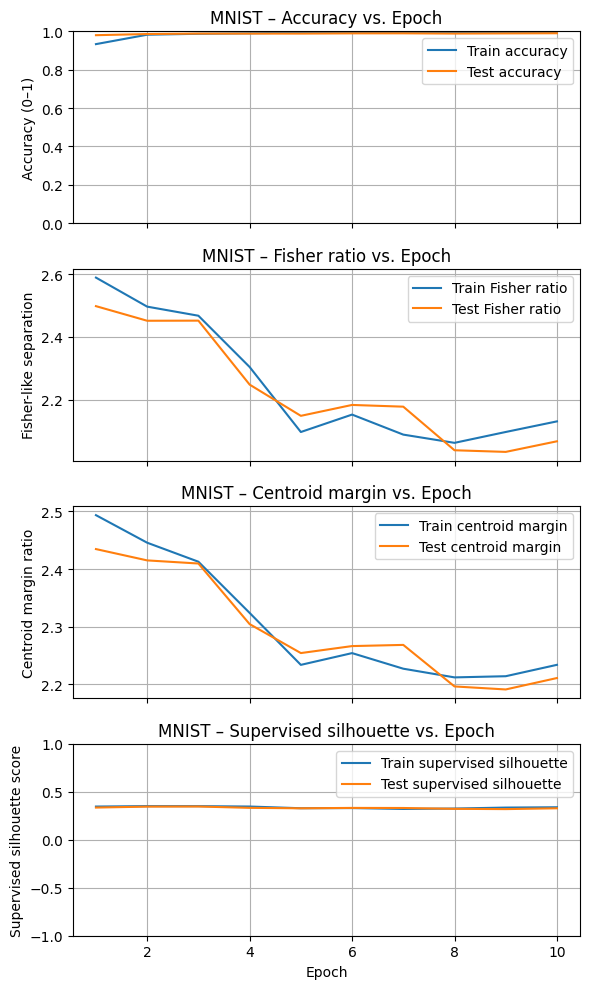

In [32]:
# Plotting accuracy and separation metrics over epochs (MNIST)

epochs = list(range(1, len(mnist_history_epochs["train_acc"]) + 1))

fig, axes = plt.subplots(4, 1, figsize=(6, 10), sharex=True)

# 1) Accuracy
axes[0].plot(epochs, mnist_history_epochs["train_acc"], label="Train accuracy")
axes[0].plot(epochs, mnist_history_epochs["test_acc"], label="Test accuracy")
axes[0].set_ylabel("Accuracy (0–1)")
axes[0].set_title("MNIST – Accuracy vs. Epoch")
axes[0].set_ylim(0.0, 1.0)  
axes[0].legend()
axes[0].grid(True)

# 2) Fisher ratio
axes[1].plot(epochs, mnist_history_epochs["train_fisher"], label="Train Fisher ratio")
axes[1].plot(epochs, mnist_history_epochs["test_fisher"], label="Test Fisher ratio")
axes[1].set_ylabel("Fisher-like separation")
axes[1].set_title("MNIST – Fisher ratio vs. Epoch")
axes[1].legend()
axes[1].grid(True)

# 3) Centroid margin ratio
axes[2].plot(epochs, mnist_history_epochs["train_centroid_margin"],
             label="Train centroid margin")
axes[2].plot(epochs, mnist_history_epochs["test_centroid_margin"],
             label="Test centroid margin")
axes[2].set_ylabel("Centroid margin ratio")
axes[2].set_title("MNIST – Centroid margin vs. Epoch")
axes[2].legend()
axes[2].grid(True)

# 4) Supervised silhouette
axes[3].plot(epochs, mnist_history_epochs["train_silhouette"],
             label="Train supervised silhouette")
axes[3].plot(epochs, mnist_history_epochs["test_silhouette"],
             label="Test supervised silhouette")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Supervised silhouette score")
axes[3].set_title("MNIST – Supervised silhouette vs. Epoch")
axes[3].set_ylim(-1.0, 1.0)  
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
fig.savefig("mnist_classsep_curves.pdf", bbox_inches="tight")
plt.show()



### CIFAR-10 – Epoch-wise evolution of accuracy and separation metrics

we repeat the epoch-wise tracking experiment, but now on the **CIFAR-10 CNN**.



We then visualize how these metrics evolve over epochs together with accuracy. This helps us observe whether separation metrics track generalization and potentially reveal overfitting.







In [34]:
# Run epoch-wise tracking on CIFAR-10 (to create cifar_history_epochs)

cifar_model_tracking = CIFAR10CNN()
cifar_penultimate_layer_tracking = find_penultimate_linear_layer(cifar_model_tracking)

cifar_history_epochs = train_with_classsep_tracking(
    model=cifar_model_tracking,
    train_loader=cifar_train_loader,      
    test_loader=cifar_test_loader,        
    device=config.device,                 
    layer=cifar_penultimate_layer_tracking,
    num_epochs=10,                        
    lr=config.lr,                        
    weight_decay=config.weight_decay,
    max_batches_repr=5,                   
)


[DEBUG] Penultimate Linear layer selected: Linear(in_features=2048, out_features=64, bias=True)

[Tracking] Training for 10 epochs on device = cpu with separation metrics every epoch

Epoch 01/10 | train_loss = 1.4604, train_acc = 46.78%, test_acc = 56.76%
    Fisher(train/test)          = 0.708 / 0.736
    CentroidMargin(train/test)  = 1.263 / 1.257
    Silhouette(train/test)      = -0.015 / -0.000
Epoch 02/10 | train_loss = 1.0558, train_acc = 62.86%, test_acc = 66.01%
    Fisher(train/test)          = 0.808 / 0.780
    CentroidMargin(train/test)  = 1.337 / 1.304
    Silhouette(train/test)      = 0.025 / 0.026
Epoch 03/10 | train_loss = 0.8560, train_acc = 70.30%, test_acc = 70.62%
    Fisher(train/test)          = 0.873 / 0.789
    CentroidMargin(train/test)  = 1.351 / 1.317
    Silhouette(train/test)      = 0.050 / 0.036
Epoch 04/10 | train_loss = 0.7389, train_acc = 74.31%, test_acc = 71.82%
    Fisher(train/test)          = 0.701 / 0.687
    CentroidMargin(train/test)  = 1.267 / 

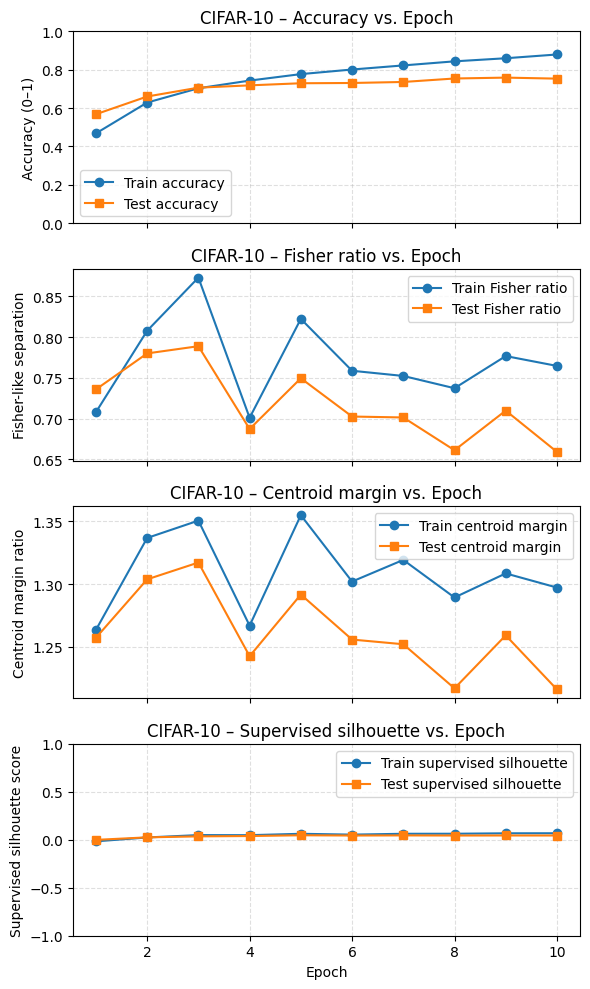

In [36]:
# CIFAR-10 – Epoch-wise evolution of accuracy and separation metrics
# ---------------------------------------------------------------------

# Build epoch index from the length of the accuracy list
epochs = list(range(1, len(cifar_history_epochs["train_acc"]) + 1))

# Create a single figure with 4 stacked subplots 
fig, axes = plt.subplots(4, 1, figsize=(6, 10), sharex=True)

# --- 1) Accuracy vs. epoch ---
axes[0].plot(epochs, cifar_history_epochs["train_acc"], marker="o", label="Train accuracy")
axes[0].plot(epochs, cifar_history_epochs["test_acc"],  marker="s", label="Test accuracy")
axes[0].set_ylabel("Accuracy (0–1)")
axes[0].set_title("CIFAR-10 – Accuracy vs. Epoch")
axes[0].set_ylim(0.0, 1.0)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.4)

# --- 2) Fisher-like ratio vs. epoch ---
axes[1].plot(epochs, cifar_history_epochs["train_fisher"], marker="o", label="Train Fisher ratio")
axes[1].plot(epochs, cifar_history_epochs["test_fisher"],  marker="s", label="Test Fisher ratio")
axes[1].set_ylabel("Fisher-like separation")
axes[1].set_title("CIFAR-10 – Fisher ratio vs. Epoch")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.4)

# --- 3) Centroid margin ratio vs. epoch ---
axes[2].plot(
    epochs,
    cifar_history_epochs["train_centroid_margin"],
    marker="o",
    label="Train centroid margin",
)
axes[2].plot(
    epochs,
    cifar_history_epochs["test_centroid_margin"],
    marker="s",
    label="Test centroid margin",
)
axes[2].set_ylabel("Centroid margin ratio")
axes[2].set_title("CIFAR-10 – Centroid margin vs. Epoch")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.4)

# --- 4) Supervised silhouette vs. epoch ---
axes[3].plot(
    epochs,
    cifar_history_epochs["train_silhouette"],
    marker="o",
    label="Train supervised silhouette",
)
axes[3].plot(
    epochs,
    cifar_history_epochs["test_silhouette"],
    marker="s",
    label="Test supervised silhouette",
)
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Supervised silhouette score")
axes[3].set_title("CIFAR-10 – Supervised silhouette vs. Epoch")
axes[3].set_ylim(-1.0, 1.0)
axes[3].legend()
axes[3].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
fig.savefig("cifar10_classsep_curves.pdf", bbox_inches="tight")
plt.show()


## 7. Discussion

In this project we proposed and implemented a small, quantitative toolbox for measuring **class separation in hidden representations** of deep neural networks. Instead of relying only on external metrics (accuracy, loss) or qualitative plots (e.g. t-SNE), we focused on **simple, architecture-agnostic scores** that can be computed directly on layer embeddings.

Concretely, we introduced three supervised metrics:

- **Fisher-like ratio** (between-class vs within-class scatter),
- **Centroid margin ratio** (average inter-class distance vs average intra-class spread),
- **Supervised silhouette-style score** (how much points are closer to their own class centroid than to other class centroids).

All three metrics are label-aware and easy to compute for any layer that can be probed as a feature extractor.



This kind of lightweight, label-aware representation analysis can complement standard evaluation practices and provide a more **XAI-oriented view** of deep neural networks, without requiring heavy visualization pipelines or model-specific tricks.
